# Loan Default Prediction - Modelling

This notebook shows the data science lifecycle for a supervised learning problem. The goal is to predict clients that will default.

Default means one of the following `loan_status` values:
- `Default`
- `Charged Off` 
- `Does not meet the credit policy. Status:Charged Off` 

The dataset used for this exercise can be downloaded from [here](https://usmart.io/org/deloitte/discovery/discovery-view-detail/1a5426d0-24f4-4f46-aeb2-7d7d8699f119)

The data dictionary can be found [here](https://github.com/Rohini2505/Lending-Club-Loan-Analysis/blob/master/LCDataDictionary.xlsx)


## Imports

The following code blocks import the required packages and set up the notebook.

In [2]:
import gc
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
%matplotlib inline

In [3]:
import janitor as jn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print
from seaborn import diverging_palette

# Show all columns in pandas
pd.set_option("display.max_columns", None)
%load_ext rich


In [4]:
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn import ensemble, model_selection, preprocessing, tree
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/yellowbrick/style/colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/yellowbrick/style/rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [5]:
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

font = {"weight": "regular", "size": 16}
plt.rc("font", **font)
plt.rc("xtick", labelsize=15)  # tick labels bigger
plt.rc("ytick", labelsize=15)  # tick labels bigger
plt.rc("savefig", dpi=300)  # higher res outputs

## Load the cleaned data

In [7]:
train_df = pd.read_parquet("mma-online/Section 2/train.parquet")
val_df = pd.read_parquet("mma-online/Section 2/val.parquet")
test_df = pd.read_parquet("mma-online/Section 2/test.parquet")

In [8]:
X_train, y_train = train_df.drop("target", axis=1), train_df["target"]
X_val, y_val = val_df.drop("target", axis=1), val_df["target"]
X_test, y_test = test_df.drop("target", axis=1), test_df["target"]

## Evaluation Metrics

Here we will define some helper functions to visualize the evaluation metrics.

### ROC Curve



In [9]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()


### PR Curve

In [10]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [11]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    """
    Function to calculate the accuracy, precision, recall, f1 score, and confusion matrix of a classifier
    on the training and validation sets.
    """

    if train:
        print("Train Result:\n")
        print(
            "accuracy score: {0:.4f}\n".format(
                accuracy_score(y_train, clf.predict(X_train))
            )
        )
        print(
            "Classification Report: \n {}\n".format(
                classification_report(y_train, clf.predict(X_train))
            )
        )
        print(
            "Confusion Matrix: \n {}\n".format(
                confusion_matrix(y_train, clf.predict(X_train))
            )
        )

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy")
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    else:
        print("Validation Result:\n")
        print(
            "accuracy score: {0:.4f}\n".format(
                accuracy_score(y_val, clf.predict(X_val))
            )
        )

        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)

        print(
            "Classification Report: \n {}\n".format(
                classification_report(y_val, clf.predict(X_val))
            )
        )
        print(
            "Confusion Matrix: \n {}\n".format(
                confusion_matrix(y_val, clf.predict(X_val))
            )
        )
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)
        print("End of validation Result\n")

### Classification Metrics

In [12]:
def evaluation_metrics(y_actual, y_pred):
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    average_precision = average_precision_score(y_actual, y_pred)
    plot_pr_curve(precision, recall, average_precision)

    fpr, tpr, _ = roc_curve(y_actual, y_pred)
    roc_auc = roc_auc_score(y_actual, y_pred)
    print("roc auc score: {}\n".format(roc_auc))
    plot_roc_curve(fpr, tpr, roc_auc)

    print(
        "Classification Report: \n {}\n".format(classification_report(y_actual, y_pred))
    )
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))


### Run model evaluation on Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

clf_log_reg_vanilla = LogisticRegression(C=0.0001, random_state=42, max_iter=500)
clf_log_reg_vanilla.fit(X_train, y_train)


LogisticRegression(C=0.0001, max_iter=500, random_state=42)

Validation Result:

accuracy score: 0.9621

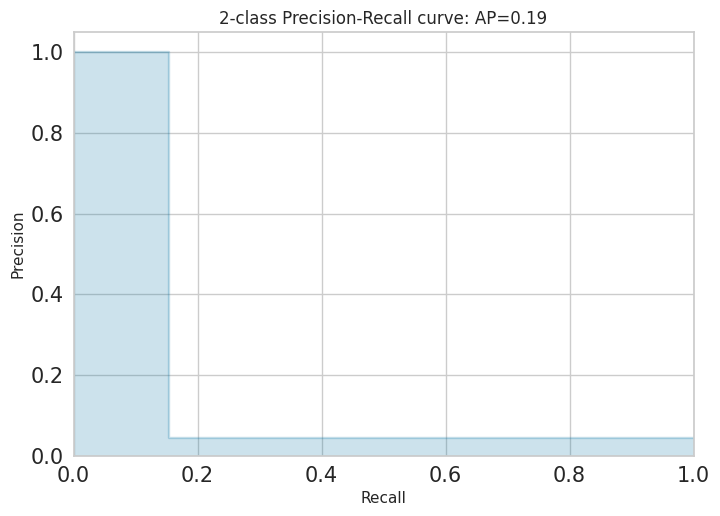

roc auc score: 0.5766703176341731

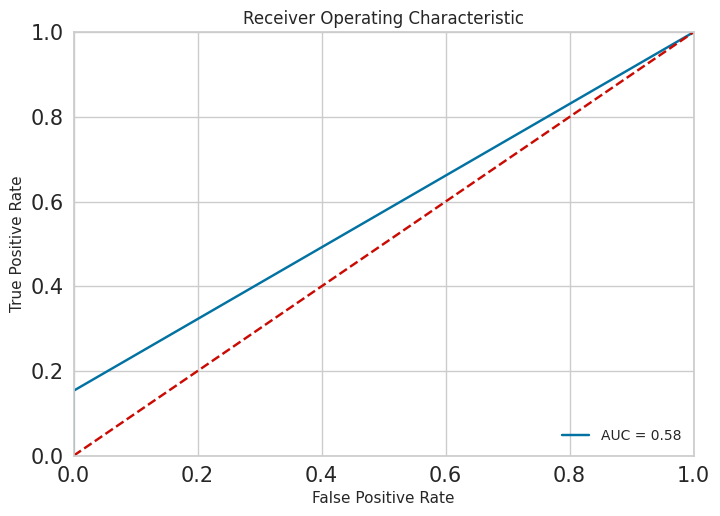

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    117030
           1       1.00      0.15      0.27      5478

    accuracy                           0.96    122508
   macro avg       0.98      0.58      0.62    122508
weighted avg       0.96      0.96      0.95    122508

Confusion Matrix: 
 [[117030      0]
 [  4638    840]]

End of validation Result

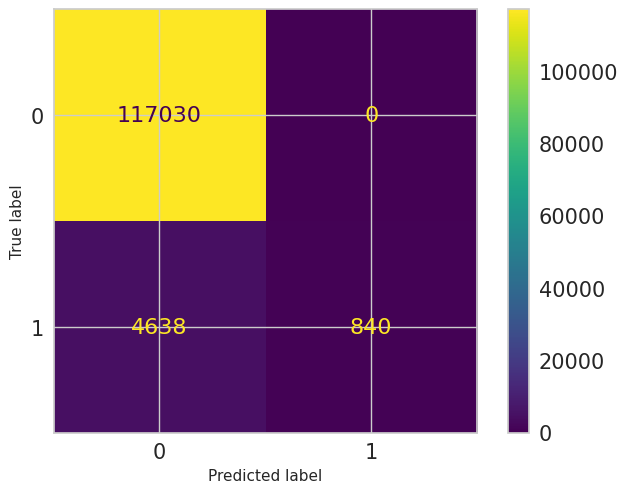

In [14]:
clf_score(clf_log_reg_vanilla, X_train, y_train, X_val, y_val, train=False)

In [15]:
len(y_val)

122508

## Dealing with imbalanced classes

This section corresponds to **Section 3.4.3** of the lecture notes: "Handling Imbalanced Classes" in *"SOTA Supervised Learning"*.

### Visualize support for each class 

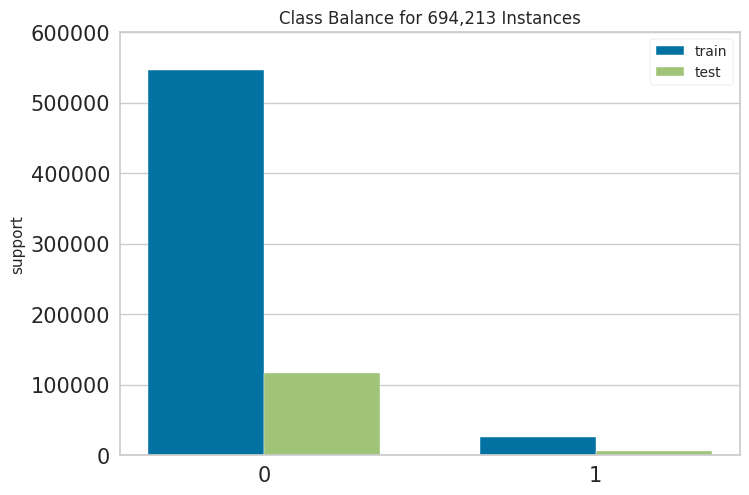

In [16]:
# Documentation: https://www.scikit-yb.org/en/latest/
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
plt.show()


### Balanced Class Weights

In classification tasks, class weights can be specified as a dictionary in the format {class_label: weight}.
By default, all classes are assigned a weight of one.

The 'balanced' mode automatically calculates weights inversely proportional to class frequencies in the input data.

This is computed as `n_samples / (n_classes * np.bincount(y))`, ensuring that each class contributes equally to the loss function.

Validation Result:

accuracy score: 0.8204

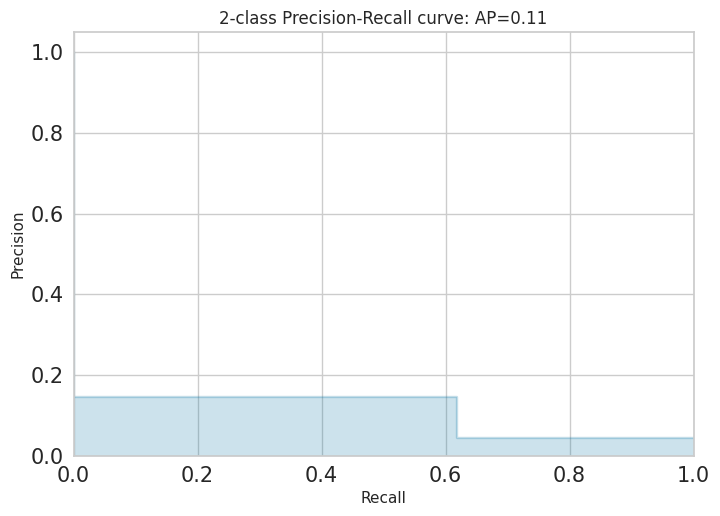

roc auc score: 0.7239208283812233

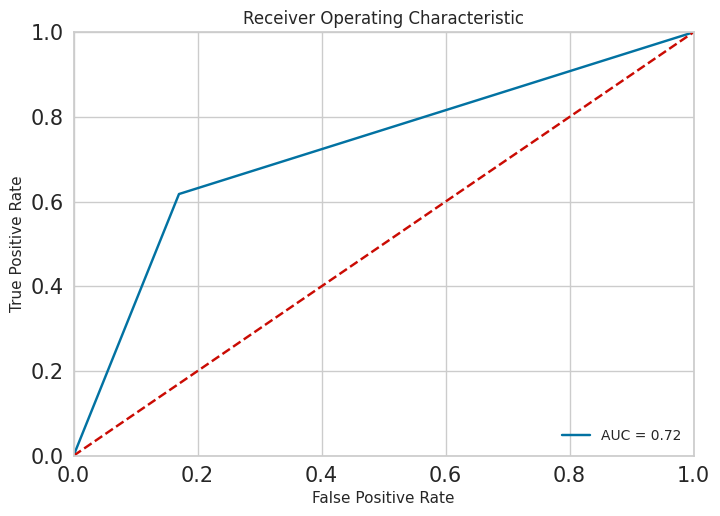

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.83      0.90    117030
           1       0.15      0.62      0.24      5478

    accuracy                           0.82    122508
   macro avg       0.56      0.72      0.57    122508
weighted avg       0.94      0.82      0.87    122508

Confusion Matrix: 
 [[97125 19905]
 [ 2093  3385]]

End of validation Result

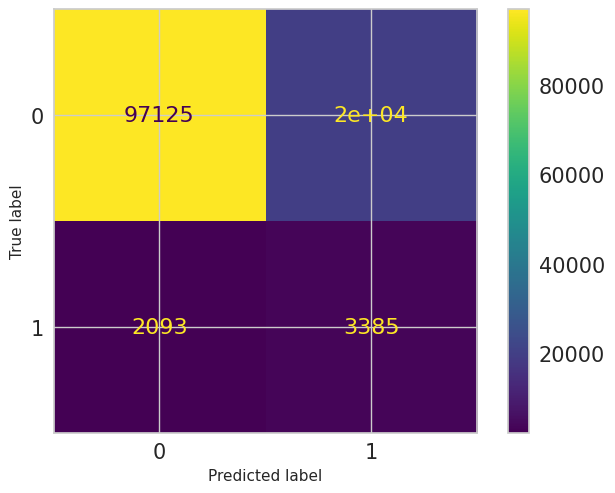

In [17]:
clf_log_reg_balanced = LogisticRegression(
    C=0.0001, random_state=42, max_iter=500, class_weight="balanced"
)
clf_log_reg_balanced.fit(X_train, y_train)
clf_score(clf_log_reg_balanced, X_train, y_train, X_val, y_val, train=False)


### SMOTE (Synthetic Minority Oversampling Technique)

Up-Sampling under represented class. More info in the [documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


#### Run Logistic Regression on up-sampled data

Validation Result:

accuracy score: 0.8090

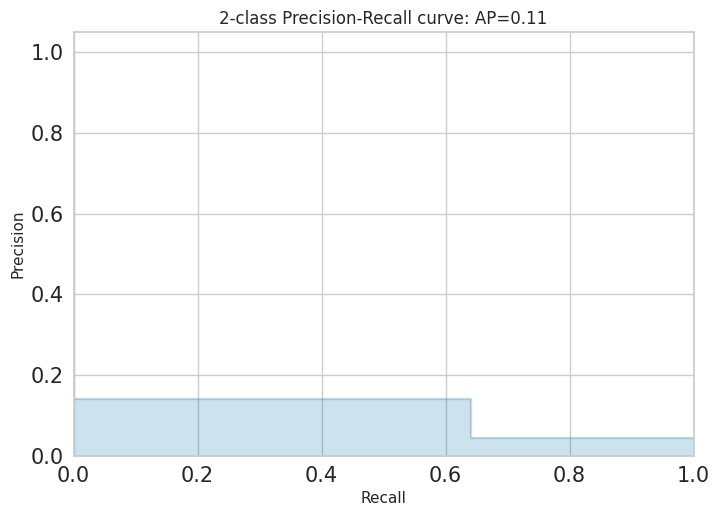

roc auc score: 0.7289929544095143

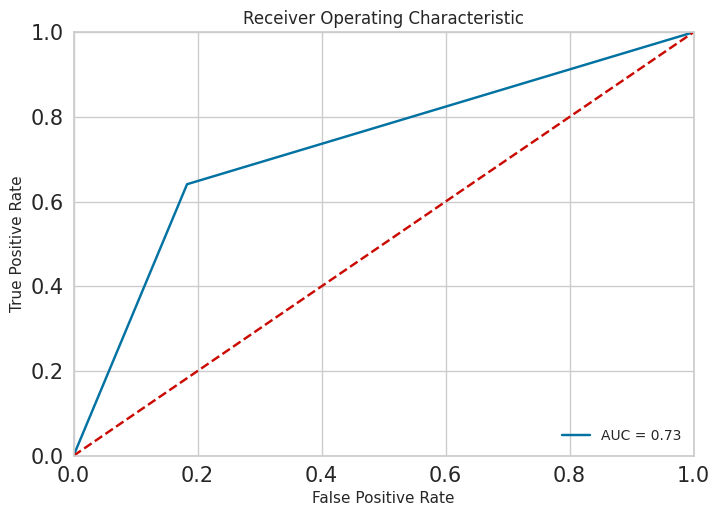

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.82      0.89    117030
           1       0.14      0.64      0.23      5478

    accuracy                           0.81    122508
   macro avg       0.56      0.73      0.56    122508
weighted avg       0.94      0.81      0.86    122508

Confusion Matrix: 
 [[95599 21431]
 [ 1966  3512]]

End of validation Result

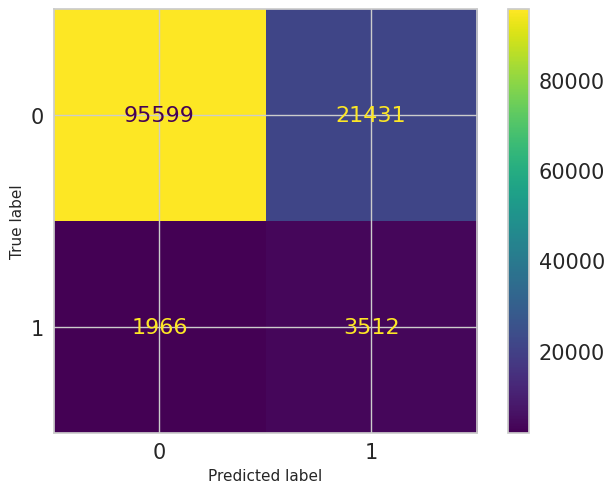

In [31]:
clf_log_reg_smote = LogisticRegression(C=0.0001, random_state=42)
clf_log_reg_smote.fit(X_train_sm, y_train_sm)
clf_score(clf_log_reg_smote, X_train_sm, y_train_sm, X_val, y_val, train=False)


#### Run Logistic Regression on up-sampled data with balanced class weights

Validation Result:

accuracy score: 0.8090

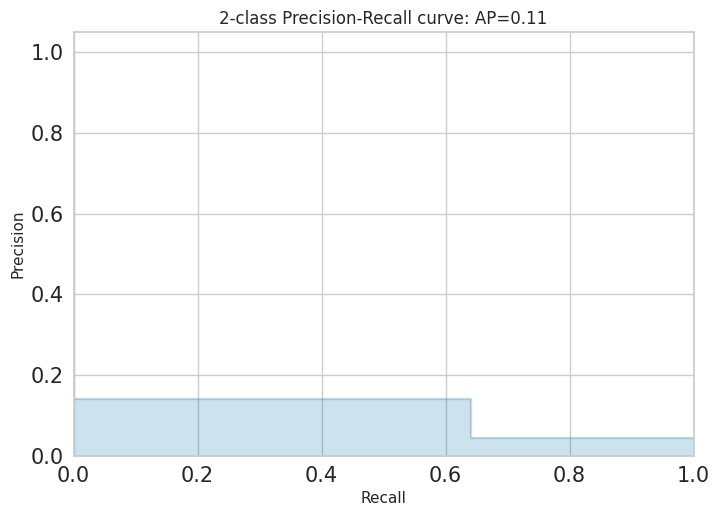

roc auc score: 0.7289929544095143

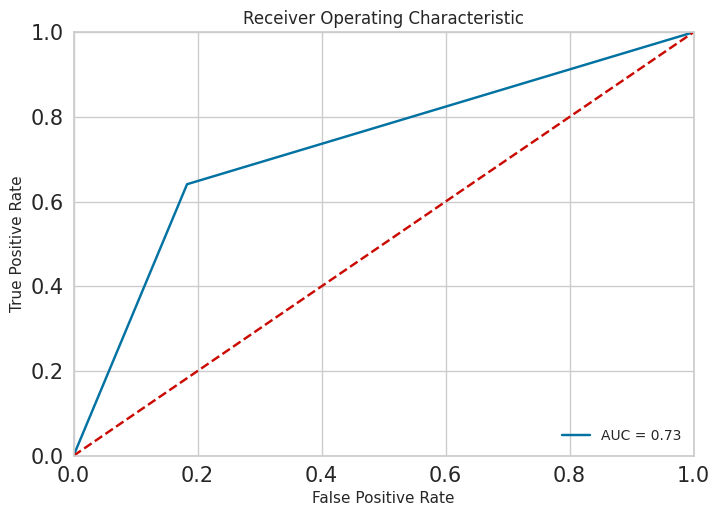

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.82      0.89    117030
           1       0.14      0.64      0.23      5478

    accuracy                           0.81    122508
   macro avg       0.56      0.73      0.56    122508
weighted avg       0.94      0.81      0.86    122508

Confusion Matrix: 
 [[95599 21431]
 [ 1966  3512]]

End of validation Result

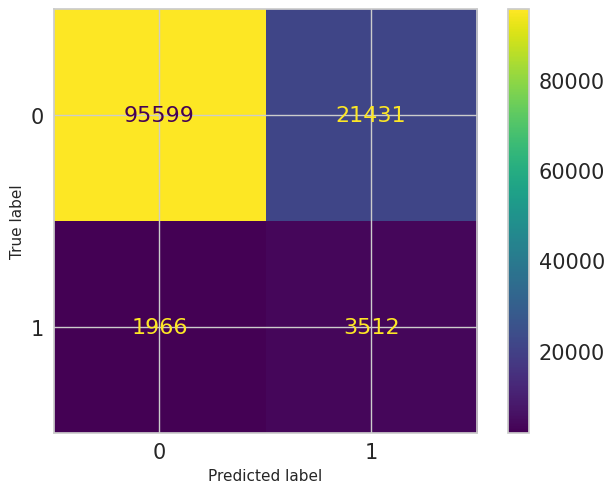

In [32]:
clf_log_reg_smote_balanced = LogisticRegression(
    C=0.0001, random_state=42, max_iter=1000, class_weight="balanced"
)
clf_log_reg_smote_balanced.fit(X_train_sm, y_train_sm)
clf_score(clf_log_reg_smote_balanced, X_train_sm, y_train_sm, X_val, y_val, train=False)

### Over-sampling

The documentation can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)

In [ ]:
from imblearn.over_sampling import (
    RandomOverSampler,
)

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
pd.Series(y_ros).value_counts()



target
0    546155
1    546155
Name: count, dtype: int64

###  Adaptive Synthetic (ADASYN)

The documentation can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html)

In [ ]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

### Balanced Random Forest Classifier

The documentation can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=0)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred = brf.predict(X_val)
balanced_accuracy_score(y_val, y_pred)

0.7701152773570102

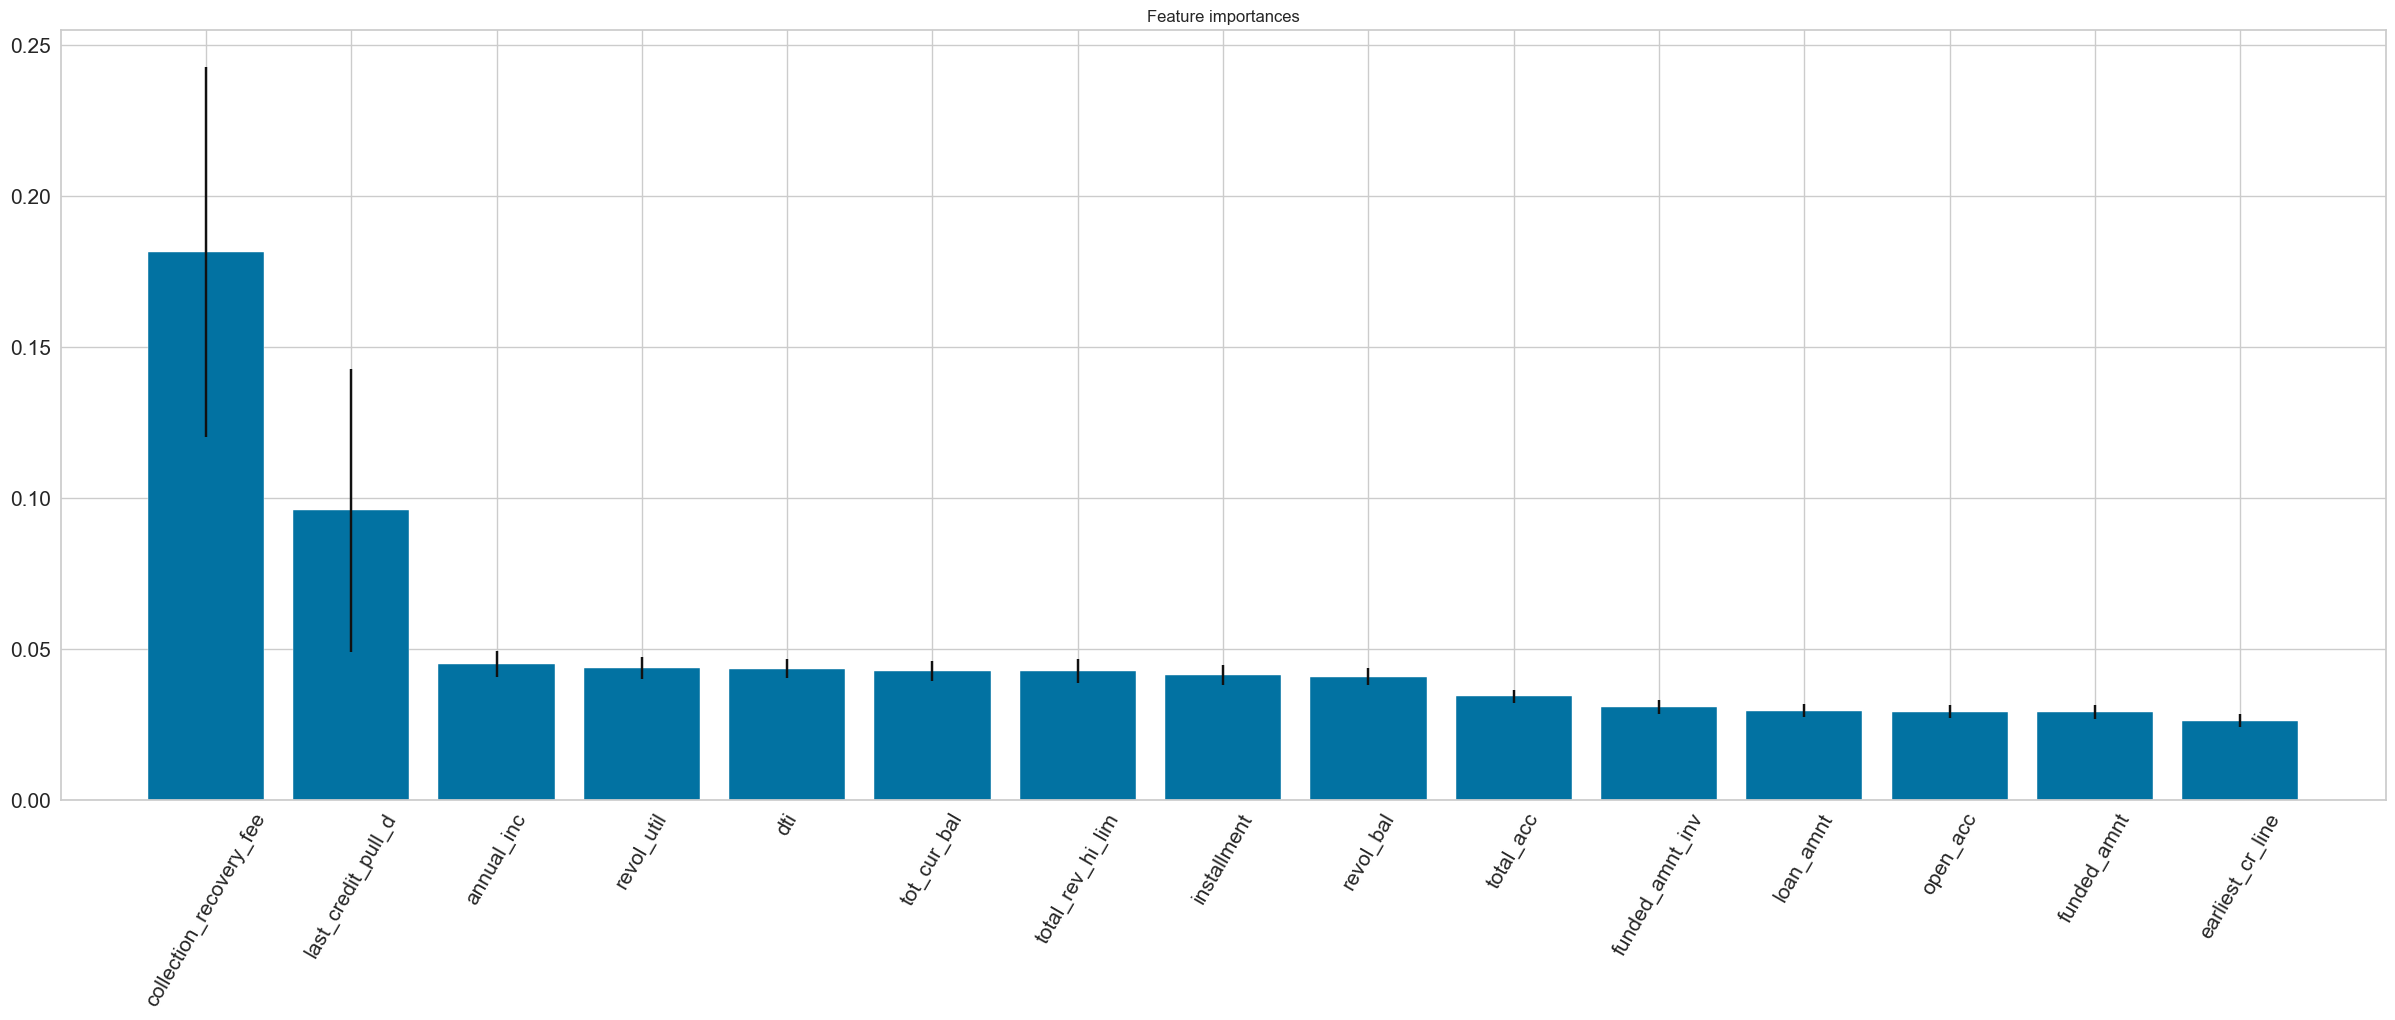

In [ ]:
importances = brf.feature_importances_

std = np.std([tree.feature_importances_ for tree in brf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
indices = indices[:15]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(X_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(30, 10))
plt.title("Feature importances")
plt.bar(
    range(len(indices)),
    importances[indices],
    color="b",
    yerr=std[indices],
    align="center",
)
plt.xticks(range(len(indices)), df.columns[indices].tolist(), rotation=60)
plt.xlim([-1, len(indices)])
plt.show()

### Combining over-sampling and under-sampling

#### SMOTEENN

The documentation can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html#smoteenn)

In [ ]:
from imblearn.combine import SMOTEENN
from collections import Counter

smote_enn = SMOTEENN(random_state=42)
X_train_smoteen, y_train_smoteen = smote_enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_smoteen).items()))


#### SMOTETomek

The documentation can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_smotetomek).items()))

## Models

### DummyClassifier

In [33]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier()
clf_dummy.fit(X_train_sm, y_train_sm)

DummyClassifier()

Validation Result:

accuracy score: 0.9553

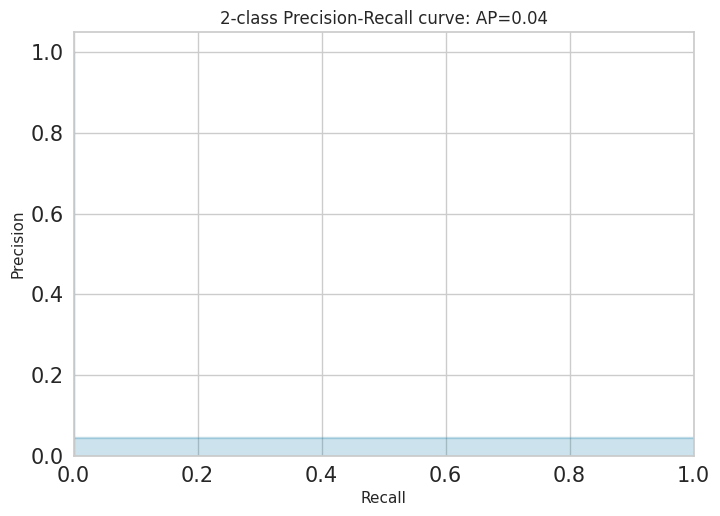

roc auc score: 0.5

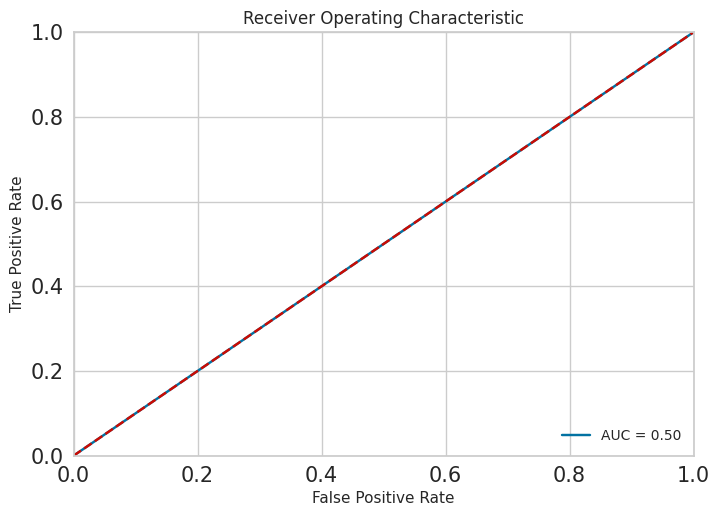

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    117030
           1       0.00      0.00      0.00      5478

    accuracy                           0.96    122508
   macro avg       0.48      0.50      0.49    122508
weighted avg       0.91      0.96      0.93    122508

Confusion Matrix: 
 [[117030      0]
 [  5478      0]]

End of validation Result

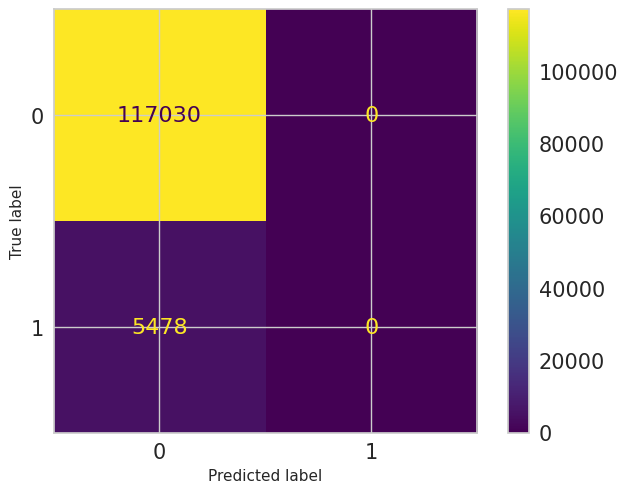

In [34]:
clf_score(clf_dummy, X_train_sm, y_train_sm, X_val, y_val, train=False)

### Logistic Regression

In [35]:
clf_log_reg = LogisticRegression(C=0.0001, random_state=42)
clf_log_reg.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.0001, random_state=42)

Validation Result:

accuracy score: 0.8090

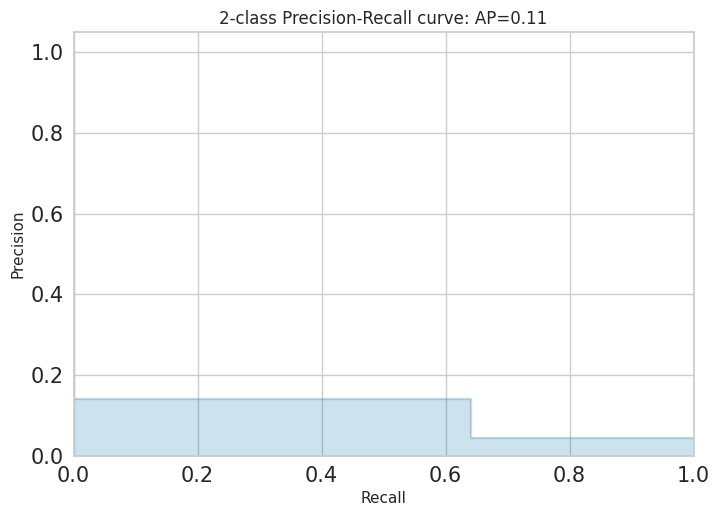

roc auc score: 0.7289929544095143

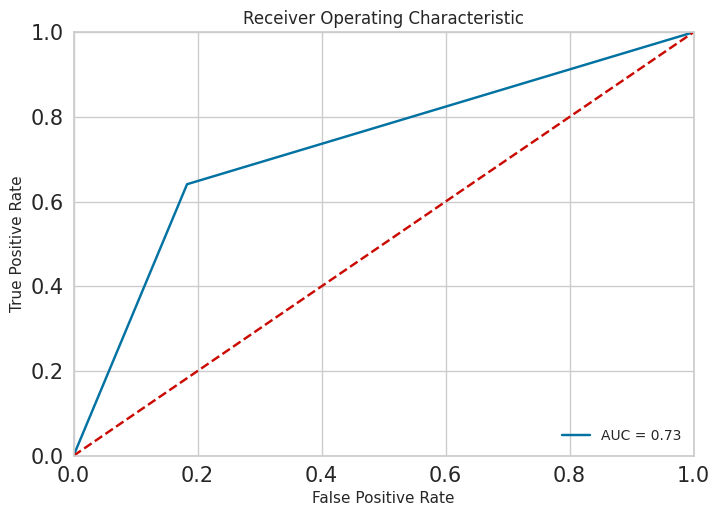

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.82      0.89    117030
           1       0.14      0.64      0.23      5478

    accuracy                           0.81    122508
   macro avg       0.56      0.73      0.56    122508
weighted avg       0.94      0.81      0.86    122508

Confusion Matrix: 
 [[95599 21431]
 [ 1966  3512]]

End of validation Result

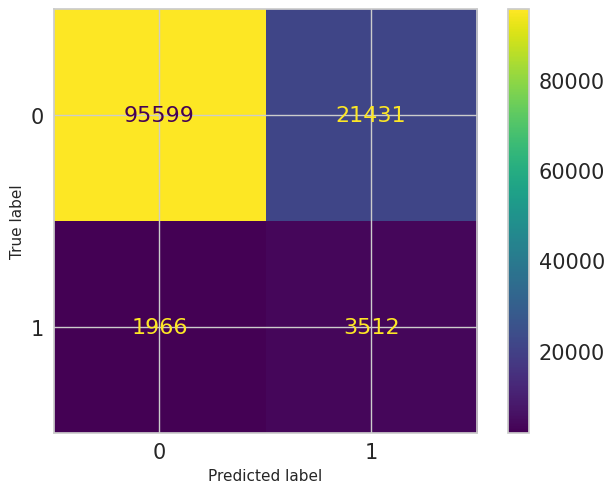

In [36]:
clf_score(clf_log_reg, X_train_sm, y_train_sm, X_val, y_val, train=False)

### Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
clf_rf = RandomForestClassifier(n_estimators=40, random_state=42)
clf_rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(n_estimators=40, random_state=42)

Validation Result:

accuracy score: 0.9747

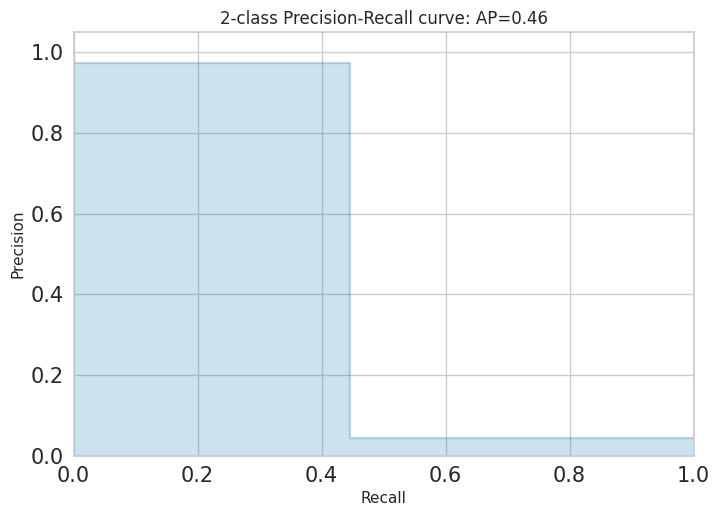

roc auc score: 0.7228876822570747

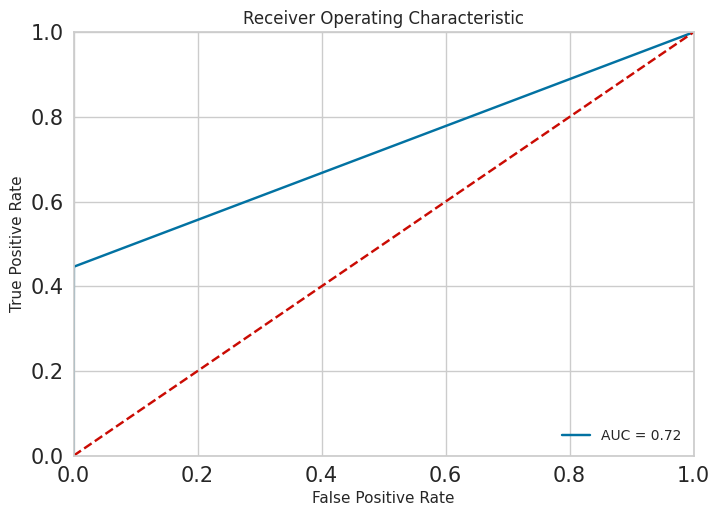

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    117030
           1       0.97      0.45      0.61      5478

    accuracy                           0.97    122508
   macro avg       0.97      0.72      0.80    122508
weighted avg       0.97      0.97      0.97    122508

Confusion Matrix: 
 [[116965     65]
 [  3033   2445]]

End of validation Result

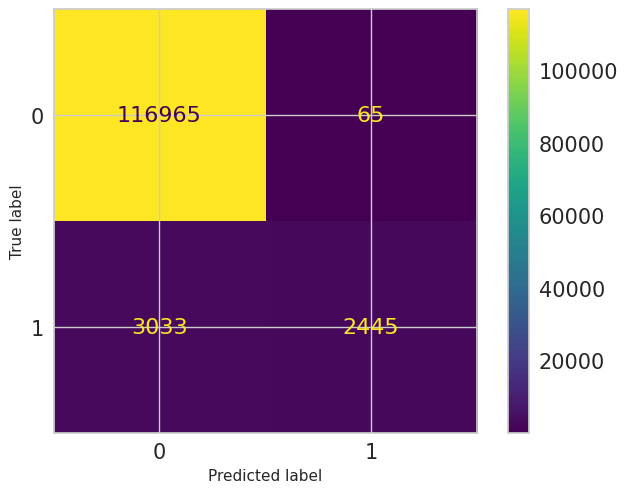

In [39]:
clf_score(clf_rf, X_train_sm, y_train_sm, X_val, y_val, train=False)

#### Evaluate model on test set

Some of these evaluations may take a long time to run, so please feel free to skip them.

##### Class Prediction Error

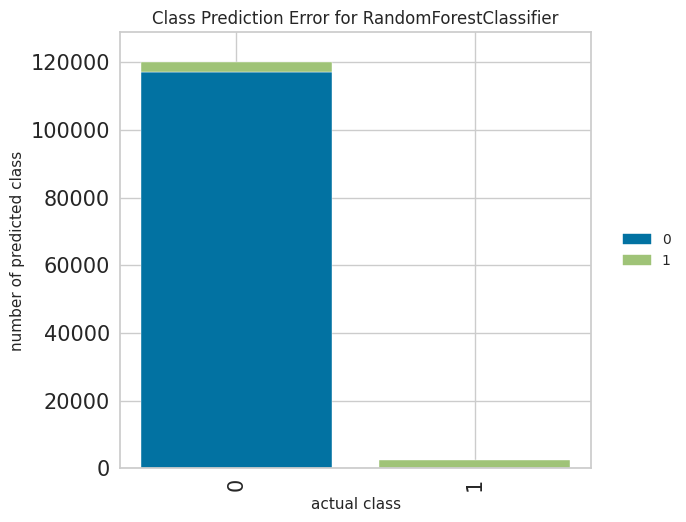

In [40]:
from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(clf_rf, classes=classes, is_fitted=True)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

plt.show()

##### Classification Report

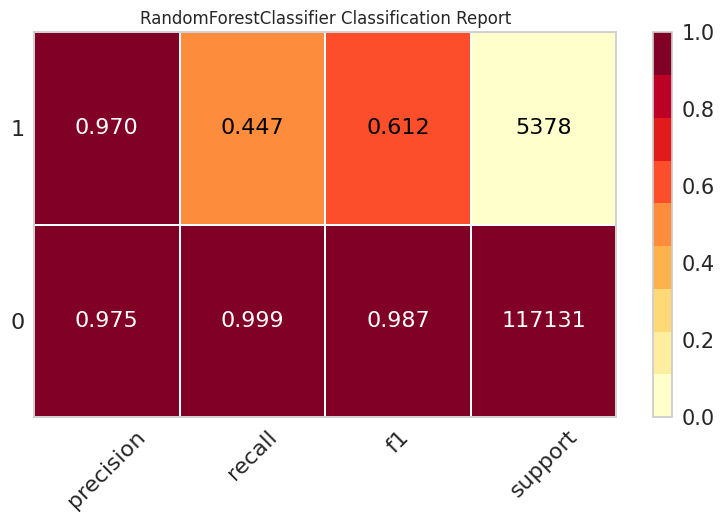

In [41]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf_rf, classes=classes, support=True, is_fitted=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure

plt.show()

##### Confusion Matrix

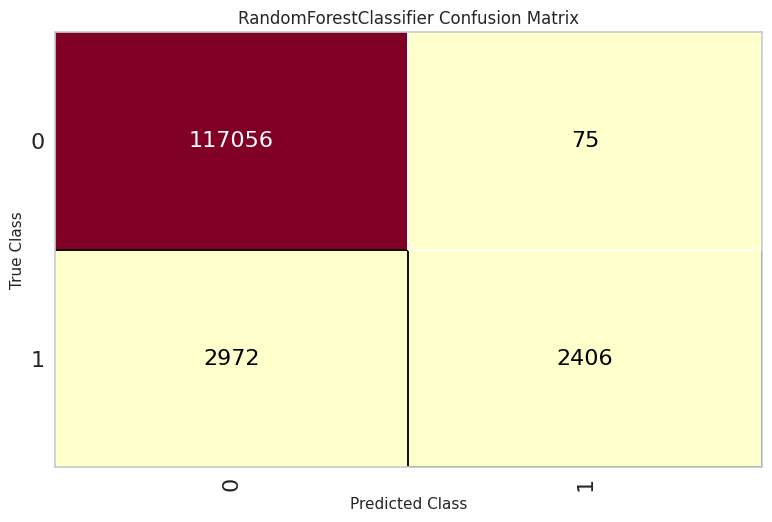

In [42]:
from yellowbrick.classifier import confusion_matrix

# The ConfusionMatrix visualizer takes a model
cm = ConfusionMatrix(clf_rf, classes=[0, 1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

plt.show()

##### PR Curve

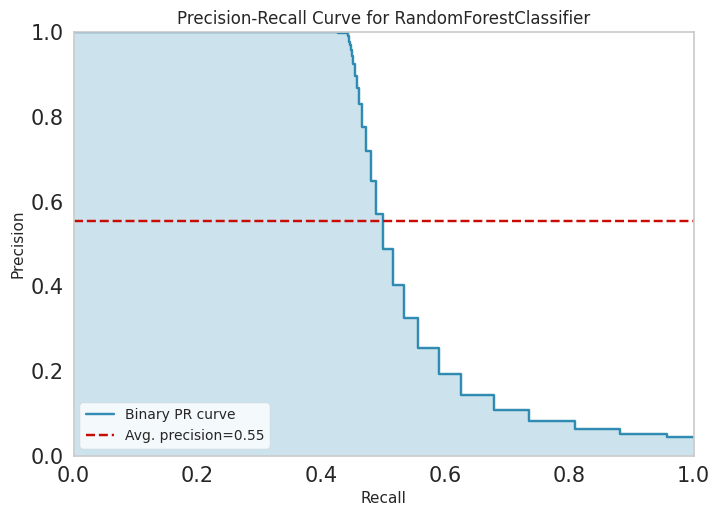

In [43]:
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_rf, is_fitted=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()
plt.show()

##### ROC-AUC

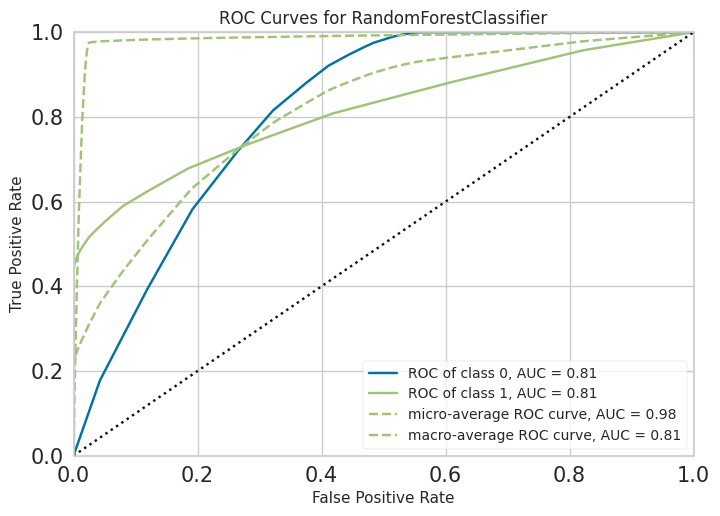

In [44]:
visualizer = ROCAUC(clf_rf, classes=classes, is_fitted=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure

plt.show()

##### Validation Curve

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


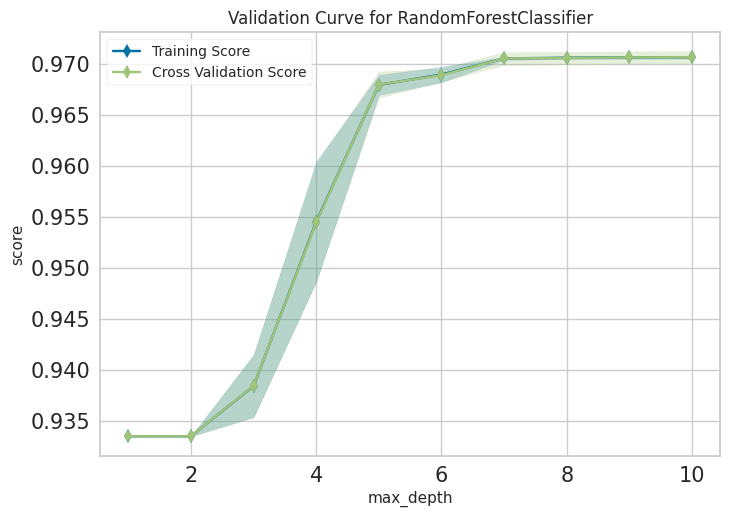

In [45]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    RandomForestClassifier(n_estimators=40, random_state=42),
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=5,
    scoring="f1_weighted",
    np_jobs=8,
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()

plt.show()

#### Learning Curve

##### Create a small dataset

In [46]:
X_train_small = X_train[:100000]
y_train_small = y_train[:100000]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


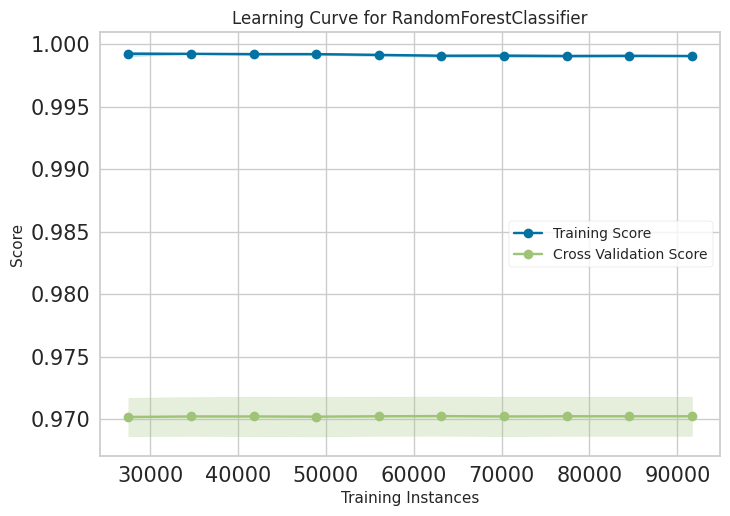

In [47]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    RandomForestClassifier(n_estimators=40, random_state=42),
    cv=cv,
    scoring="f1_weighted",
    train_sizes=sizes,
    n_jobs=8,
)

visualizer.fit(X_train_small, y_train_small)  # Fit the data to the visualizer
visualizer.poof()  # Finalize and render the figure

plt.show()

#### Discrimintation Threshold

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


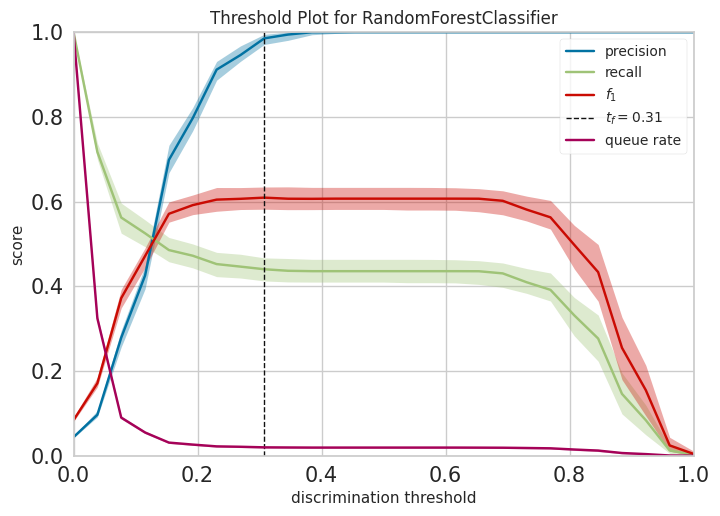

In [48]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(clf_rf, is_fitted=True)

visualizer.fit(X_train_small, y_train_small)
visualizer.poof()

plt.show()

#### Decision Function

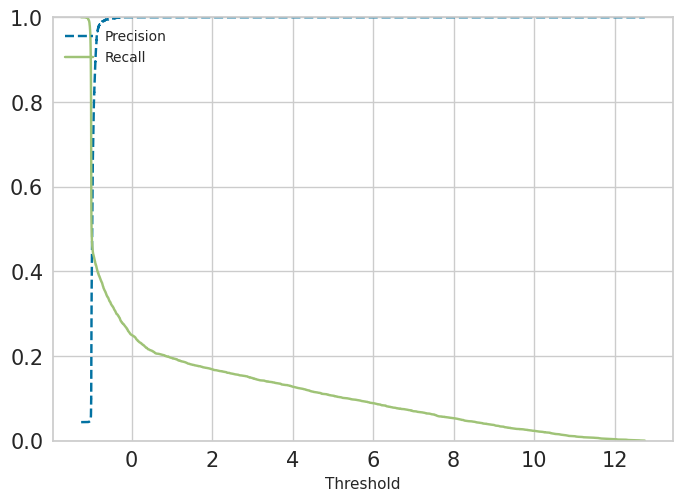

In [49]:
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC

clf_svc = SVC(gamma="auto")
clf_svc.fit(X_train_small, y_train_small)

# call decision_function on classifier to get scores (probas_pred)
probas_pred = clf_svc.decision_function(X_test)
# compute precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred)
# precision and recall vs. the decision threshold
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#### Feature Importances

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


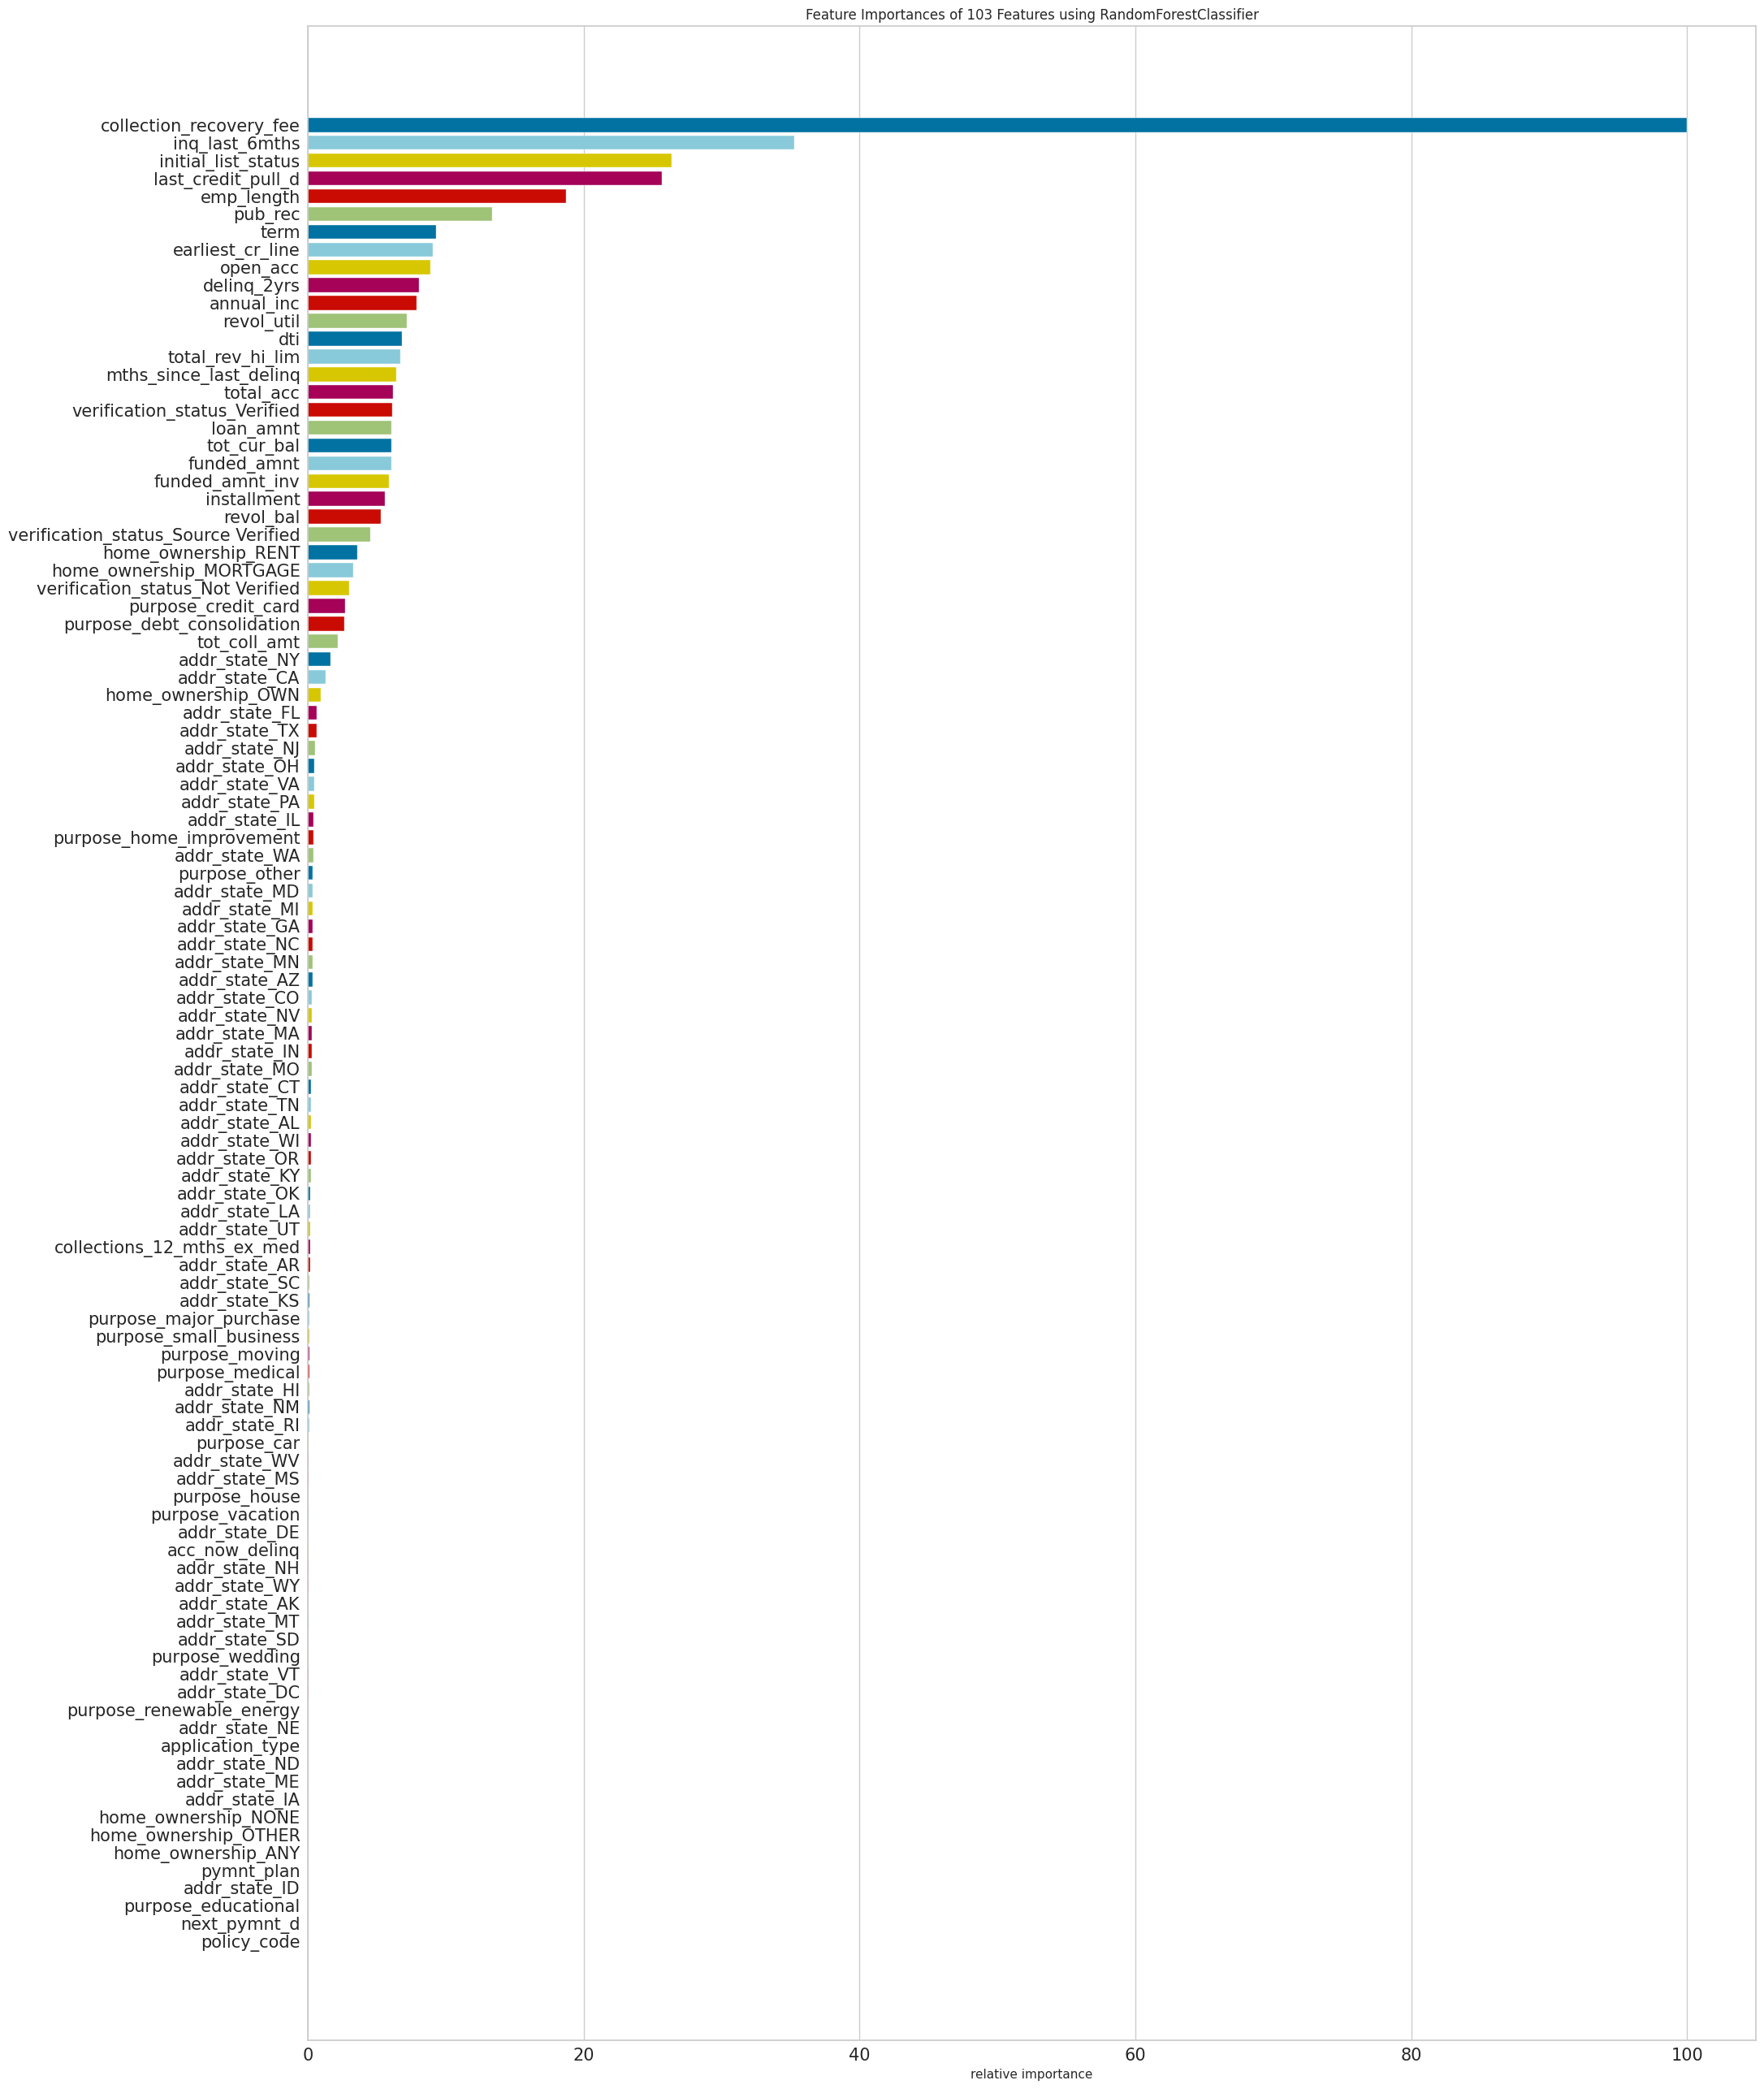

<Axes: title={'center': 'Feature Importances of 103 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [50]:
from yellowbrick.model_selection import FeatureImportances

fig = plt.figure(figsize=(22, 26))
viz = FeatureImportances(clf_rf, labels=X_train.columns)
viz.fit(X_train_small, y_train_small)
viz.poof()

In [51]:
for col, val in sorted(
    zip(
        X_train.columns,
        clf_rf.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

collection_recovery_fee     0.267

inq_last_6mths     0.094

initial_list_status     0.070

last_credit_pull_d     0.069

emp_length     0.050

### Hyperparameter tuning with Grid Search

In [52]:
clf_rf_grid = ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV(clf_rf_grid, params, n_jobs=-1).fit(
    X_train_small, y_train_small
)
print(cv.best_params_)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validat

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}

### Use best hyperparameters with RF

In [53]:
clf_rf_best = ensemble.RandomForestClassifier(
    **{
        "max_features": "auto",
        "min_samples_leaf": 1,
        "n_estimators": 200,
        "random_state": 42,
    }
)
clf_rf_best.fit(X_train, y_train)
clf_rf_best.score(X_test, y_test)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 │   │   "random_state": 42,                                                                 │
│    7 │   }                                                                                       │
│    8 )                                                                                           │
│ ❱  9 clf_rf_best.fit(X_train, y_train)                                                           │
│   10 clf_rf_best.score(X_test, y_test)                                                           │
│   11                                                                                             │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:1145 in       │
│ wrapper                                                                                          │
│                                                                                                  │
│   1142 │   │   │   )                                                                             │
│   1143 │   │   │                                                                                 │
│   1144 │   │   │   if not global_skip_validation and not partial_fit_and_fitted:                 │
│ ❱ 1145 │   │   │   │   estimator._validate_params()                                              │
│   1146 │   │   │                                                                                 │
│   1147 │   │   │   with config_context(                                                          │
│   1148 │   │   │   │   skip_parameter_validation=(                                               │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:638 in        │
│ _validate_params                                                                                 │
│                                                                                                  │
│    635 │   │   the docstring of `validate_parameter_constraints` for a description of the        │
│    636 │   │   accepted constraints.                                                             │
│    637 │   │   """                                                                               │
│ ❱  638 │   │   validate_parameter_constraints(                                                   │
│    639 │   │   │   self._parameter_constraints,                                                  │
│    640 │   │   │   self.get_params(deep=False),                                                  │
│    641 │   │   │   caller_name=self.__class__.__name__,                                          │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/_param_validati │
│ on.py:96 in validate_parameter_constraints                                                       │
│                                                                                                  │
│    93 │   │   │   │   │   f" {constraints[-1]}"                                                  │
│    94 │   │   │   │   )                                                                          │
│    95 │   │   │                                                                                  │
│ ❱  96 │   │   │   raise InvalidParameterError(                                                   │
│    97 │   │   │   │   f"The {param_name!r} parameter of {ca

In [ ]:
clf_score(clf_rf_best, X_train_sm, y_train_sm, X_test, y_test, train=False)

KeyboardInterrupt: 

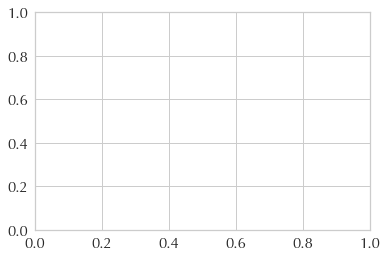

In [ ]:
from yellowbrick.features import RFECV

fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(
    ensemble.RandomForestClassifier(n_estimators=100),
    cv=5,
)
rfe.fit(X_train_small, y_train_small)
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_
rfe.poof()

plt.show()

## LightGBM

In [20]:
!pip install lightgbm

In [21]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

In [32]:
def train_lightgbm_cv(df_train, num_folds):
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    feature_names = [f for f in df_train.columns if f not in ["target"]]

    for n_fold, (train_idx, valid_idx) in enumerate(
        folds.split(df_train[feature_names], df_train["target"])
    ):
        X_train, y_train = (
            df_train[feature_names].iloc[train_idx],
            df_train["target"].iloc[train_idx],
        )
        X_val, y_val = (
            df_train[feature_names].iloc[valid_idx],
            df_train["target"].iloc[valid_idx],
        )

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            n_jobs=1,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            random_state=42,
        )

        # Fit the model and evaluate with AUC
        clf.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric="auc",
        )

        clf_score(clf, X_train, y_train, X_val, y_val, train=False)

        return clf

In [33]:
df = pd.concat([train_df, val_df], axis=0)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collection_recovery_fee,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,target
0,0.591312,0.591313,0.592295,1.506077,0.200384,-0.495121,0.523138,-0.002957,0.292627,0.762493,-0.515876,-0.700091,-0.673814,0.055779,-0.354027,-0.621374,0.117862,0.041450,0.947956,-0.080956,0.0,-0.352001,-0.112733,0.0,-0.025414,-0.066385,0.032196,1.328832,-0.717016,-0.002291,0.991325,-0.007598,-0.007482,-0.334341,-0.807984,1.559188,-0.785232,-0.697263,-0.090888,-0.560709,-1.221920,-0.001323,-0.247085,-0.060849,-0.132658,-0.096114,-0.074884,4.620478,-0.022837,-0.095612,-0.071416,-0.032736,-0.049404,-0.113372,-0.086337,-0.153586,-0.410069,-0.14738,-0.12285,-0.050946,-0.052743,-0.270866,5.444079,-0.072203,-0.00187,-0.002291,-0.204230,-0.131017,-0.095248,-0.098902,-0.110407,-0.152365,-0.155921,-0.025102,-0.164932,-0.135972,-0.128142,-0.068138,-0.053996,-0.170157,-0.024466,-0.037714,-0.069497,-0.196197,-0.074884,-0.11977,-0.298682,-0.186822,-0.096308,-0.112099,-0.191313,-0.066512,-0.110739,-0.045709,-0.12644,-0.296264,-0.084844,-0.172966,-0.045555,-0.148971,-0.115529,-0.070994,-0.048198,0
1,-0.118812,-0.118811,-0.121070,-0.663977,0.151615,-0.495121,-0.008697,-0.002957,0.309735,-0.373192,0.661878,1.385445,-0.093898,-0.691774,1.350400,-0.421331,1.050652,0.041450,-1.054901,-0.080956,0.0,-0.352001,-0.112733,0.0,-0.025414,-0.066385,-0.018721,0.766907,-0.606216,-0.002291,0.991325,-0.007598,-0.007482,-0.334341,-0.807984,1.559188,-0.785232,-0.697263,-0.090888,1.783457,-1.221920,-0.001323,-0.247085,-0.060849,-0.132658,-0.096114,-0.074884,-0.216428,-0.022837,-0.095612,-0.071416,-0.032736,-0.049404,-0.113372,-0.086337,-0.153586,-0.410069,-0.14738,-0.12285,-0.050946,-0.052743,-0.270866,-0.183686,-0.072203,-0.00187,-0.002291,4.896437,-0.131017,-0.095248,-0.098902,-0.110407,-0.152365,-0.155921,-0.025102,-0.164932,-0.135972,-0.128142,-0.068138,-0.053996,-0.170157,-0.024466,-0.037714,-0.069497,-0.196197,-0.074884,-0.11977,-0.298682,-0.186822,-0.096308,-0.112099,-0.191313,-0.066512,-0.110739,-0.045709,-0.12644,-0.296264,-0.084844,-0.172966,-0.045555,-0.148971,-0.115529,-0.070994,-0.048198,0
2,0.591312,0.591313,0.592295,-0.663977,0.994552,0.313695,0.143256,-0.002957,-0.106237,-0.373192,-0.810315,-0.700091,-0.093898,-0.504886,-0.354027,-0.146775,0.650277,-0.717804,-1.054901,-0.080956,0.0,-0.352001,-0.112733,0.0,-0.025414,-0.066385,-0.001504,0.435140,-0.335971,-0.002291,0.991325,-0.007598,-0.007482,-0.334341,-0.807984,-0.641359,-0.785232,1.434179,-0.090888,-0.560709,0.818384,-

In [34]:
clf_lgbm_cv = train_lightgbm_cv(df, num_folds=3)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 clf_lgbm_cv = train_lightgbm_cv(df, num_folds=3)                                             │
│   2                                                                                              │
│                                                                                                  │
│ in train_lightgbm_cv:37                                                                          │
│                                                                                                  │
│   34 │   │   )                                                                                   │
│   35 │   │                                                                                       │
│   36 │   │   # Fit the model and evaluate with AUC                                               │
│ ❱ 37 │   │   clf.fit(                                                                            │
│   38 │   │   │   X_train,                                                                        │
│   39 │   │   │   y_train,                                                                        │
│   40 │   │   │   eval_set=[(X_train, y_train), (X_val, y_val)],                                  │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightgbm/sklearn.py:1284 in   │
│ fit                                                                                              │
│                                                                                                  │
│   1281 │   │   │   │   else:                                                                     │
│   1282 │   │   │   │   │   valid_sets.append((valid_x, self._le.transform(valid_y)))             │
│   1283 │   │                                                                                     │
│ ❱ 1284 │   │   super().fit(                                                                      │
│   1285 │   │   │   X,                                                                            │
│   1286 │   │   │   _y,                                                                           │
│   1287 │   │   │   sample_weight=sample_weight,                                                  │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightgbm/sklearn.py:955 in    │
│ fit                                                                                              │
│                                                                                                  │
│    952 │   │   evals_result: _EvalResultDict = {}                                                │
│    953 │   │   callbacks.append(record_evaluation(evals_result))                                 │
│    954 │   │                                                                                     │
│ ❱  955 │   │   self._Booster = train(                                                            │
│    956 │   │   │   params=params,                                                                │
│    957 │   │   │   train_set=train_set,                                                          │
│    958 │   │   │   num_boost_round=self.n_estimators,                                            │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightgbm/engine.py:313 in     │
│ train                                                      

### Feature Importance

In [ ]:
def display_lgbm_feature_importances(df_feature_importance):
    cols = (
        df_feature_importance[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:40]
        .index
    )
    best_features = df_feature_importance.loc[df_feature_importance.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()
    plt.savefig("lgbm_importances.png")


In [ ]:
def lgbm_feature_importance(df_train, clf, num_folds):
    feature_names = [f for f in df_train.columns if f not in ["target"]]

    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = feature_names
    df_fold_importance["importance"] = clf.feature_importances_
    df_fold_importance["fold"] = num_folds + 1

    df_feature_importance = pd.DataFrame()
    df_feature_importance = pd.concat(
        [df_feature_importance, df_fold_importance], axis=0
    )

    display_lgbm_feature_importances(df_feature_importance)

In [ ]:
lgbm_feature_importance(df, clf_lgbm_cv, 3)

## XGBoost

In [35]:
# free up some memory
gc.collect()

388

In [36]:
!pip install xgboost 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 158.5 MB/s eta 0:00:0000:0100:01


In [37]:
import xgboost as xgb

In [38]:
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Validation Result:

accuracy score: 0.9749

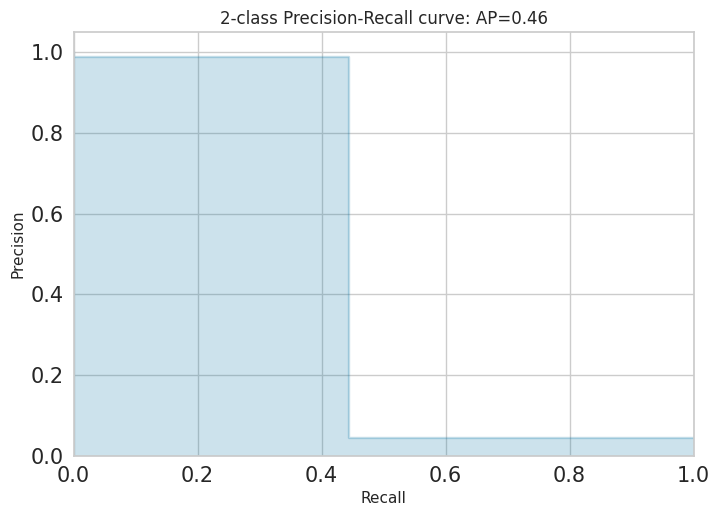

roc auc score: 0.721755105528497

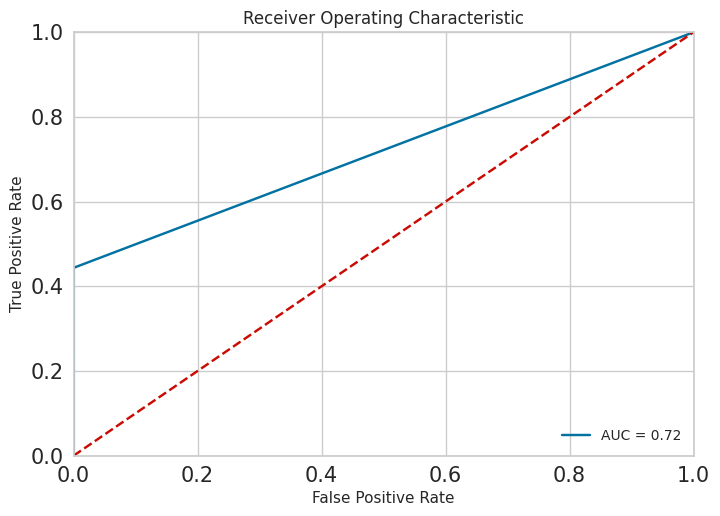

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    117030
           1       0.99      0.44      0.61      5478

    accuracy                           0.97    122508
   macro avg       0.98      0.72      0.80    122508
weighted avg       0.98      0.97      0.97    122508

Confusion Matrix: 
 [[116999     31]
 [  3047   2431]]

End of validation Result

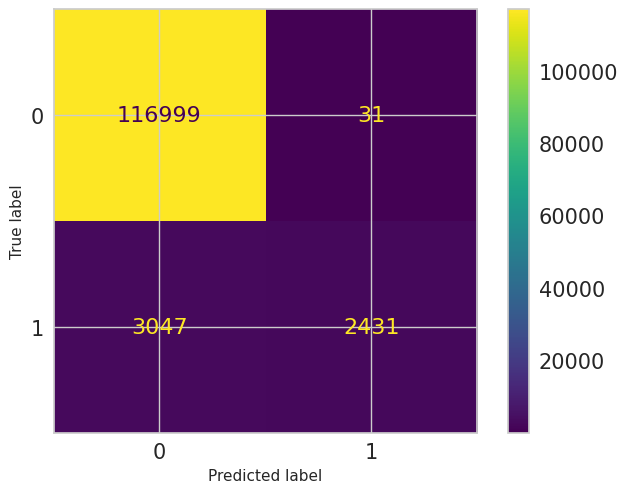

In [39]:
clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)

### Explainability

In [40]:
! pip install graphviz

#### Visualizing the model

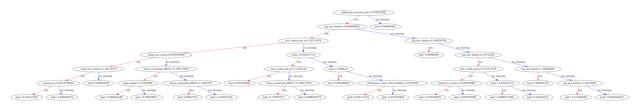

In [41]:
xgb.plot_tree(clf_xgb, num_trees=0)
plt.rcParams["figure.figsize"] = [100, 100]
plt.show()

#### Feature Importance

In [42]:
xgb.plot_importance(clf_xgb)
plt.rcParams["figure.figsize"] = [22, 6]
plt.show()

## AdaBoost

In [43]:
from sklearn.ensemble import AdaBoostClassifier

In [44]:
clf_ada_boost = AdaBoostClassifier(n_estimators=100, random_state=42)
clf_ada_boost.fit(X_train_sm, y_train_sm)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 clf_ada_boost = AdaBoostClassifier(n_estimators=100, random_state=42)                        │
│ ❱ 2 clf_ada_boost.fit(X_train_sm, y_train_sm)                                                    │
│   3                                                                                              │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:1152 in       │
│ wrapper                                                                                          │
│                                                                                                  │
│   1149 │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation               │
│   1150 │   │   │   │   )                                                                         │
│   1151 │   │   │   ):                                                                            │
│ ❱ 1152 │   │   │   │   return fit_method(estimator, *args, **kwargs)                             │
│   1153 │   │                                                                                     │
│   1154 │   │   return wrapper                                                                    │
│   1155                                                                                           │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/ensemble/_weight_boos │
│ ting.py:171 in fit                                                                               │
│                                                                                                  │
│    168 │   │   │   sample_weight[zero_weight_mask] = 0.0                                         │
│    169 │   │   │                                                                                 │
│    170 │   │   │   # Boosting step                                                               │
│ ❱  171 │   │   │   sample_weight, estimator_weight, estimator_error = self._boost(               │
│    172 │   │   │   │   iboost, X, y, sample_weight, random_state                                 │
│    173 │   │   │   )                                                                             │
│    174                                                                                           │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/ensemble/_weight_boos │
│ ting.py:579 in _boost                                                                            │
│                                                                                                  │
│    576 │   │   │   If None then boosting has terminated early.                                   │
│    577 │   │   """                                                                               │
│    578 │   │   if self.algorithm == "SAMME.R":                                                   │
│ ❱  579 │   │   │   return self._boost_real(iboost, X, y, sample_weight, random_state)            │
│    580 │   │                                                                                     │
│    581 │   │   else:  # elif self.algorithm == "SAMME":                                          │
│    582 │   │   │   return self._boost_discrete(iboost, X, y, sample_weight, random_state)        │
│                                                            

In [45]:
clf_score(clf_ada_boost, X_train_sm, y_train_sm, X_val, y_val, train=False)

Validation Result:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 clf_score(clf_ada_boost, X_train_sm, y_train_sm, X_val, y_val, train=False)                  │
│   2                                                                                              │
│                                                                                                  │
│ in clf_score:33                                                                                  │
│                                                                                                  │
│   30 │   │   print("Validation Result:\n")                                                       │
│   31 │   │   print(                                                                              │
│   32 │   │   │   "accuracy score: {0:.4f}\n".format(                                             │
│ ❱ 33 │   │   │   │   accuracy_score(y_val, clf.predict(X_val))                                   │
│   34 │   │   │   )                                                                               │
│   35 │   │   )                                                                                   │
│   36                                                                                             │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/ensemble/_weight_boos │
│ ting.py:710 in predict                                                                           │
│                                                                                                  │
│    707 │   │   y : ndarray of shape (n_samples,)                                                 │
│    708 │   │   │   The predicted classes.                                                        │
│    709 │   │   """                                                                               │
│ ❱  710 │   │   pred = self.decision_function(X)                                                  │
│    711 │   │                                                                                     │
│    712 │   │   if self.n_classes_ == 2:                                                          │
│    713 │   │   │   return self.classes_.take(pred > 0, axis=0)                                   │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/ensemble/_weight_boos │
│ ting.py:778 in decision_function                                                                 │
│                                                                                                  │
│    775 │   │                                                                                     │
│    776 │   │   if self.algorithm == "SAMME.R":                                                   │
│    777 │   │   │   # The weights are all 1. for SAMME.R                                          │
│ ❱  778 │   │   │   pred = sum(                                                                   │
│    779 │   │   │   │   _samme_proba(estimator, n_classes, X) for estimator in self.estimators_   │
│    780 │   │   │   )                                                                             │
│    781 │   │   else:  # self.algorithm == "SAMME"                                                │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/ensemble/_weight_boos │
│ ting.py:779 in <genexpr>                                   

## CatBoost

In [46]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 172.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 149.6 MB/s eta 0:00:00


In [47]:
from catboost import CatBoostClassifier, Pool

In [48]:
cls_cat_boost = CatBoostClassifier(
    iterations=2, depth=2, learning_rate=1, loss_function="Logloss", verbose=True
)
# train the model
cls_cat_boost.fit(X_train_sm, y_train_sm)

0:	learn: 0.4090535	total: 129ms	remaining: 129ms
1:	learn: 0.3442949	total: 208ms	remaining: 0us


In [49]:
# make the prediction using the resulting model
preds_class = cls_cat_boost.predict(X_val)
preds_proba = cls_cat_boost.predict_proba(X_val)
print("class = ", preds_class)
print("proba = ", preds_proba)

class =  [0 0 0 ... 0 0 0]

proba =  [[0.71983772 0.28016228]
 [0.81474437 0.18525563]
 [0.81474437 0.18525563]
 ...
 [0.81474437 0.18525563]
 [0.81474437 0.18525563]
 [0.81474437 0.18525563]]

Validation Result:

accuracy score: 0.9750

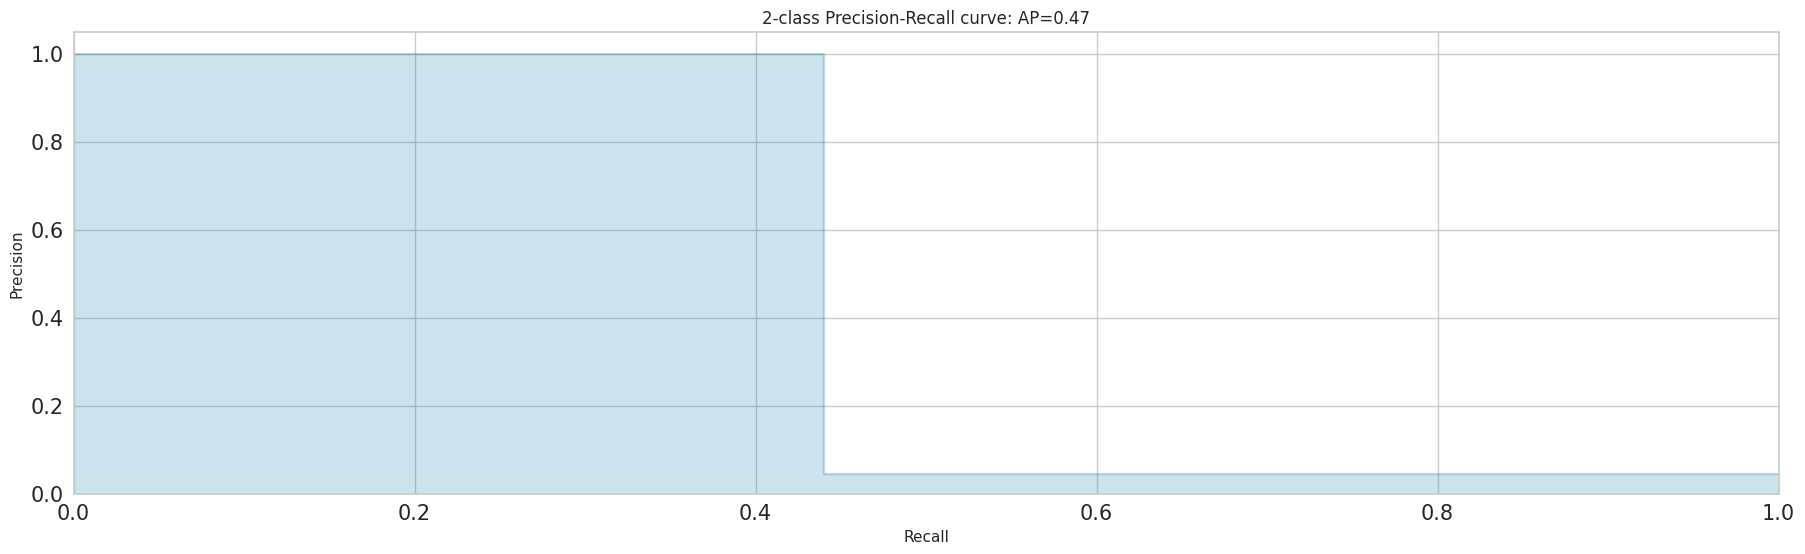

roc auc score: 0.7201533406352684

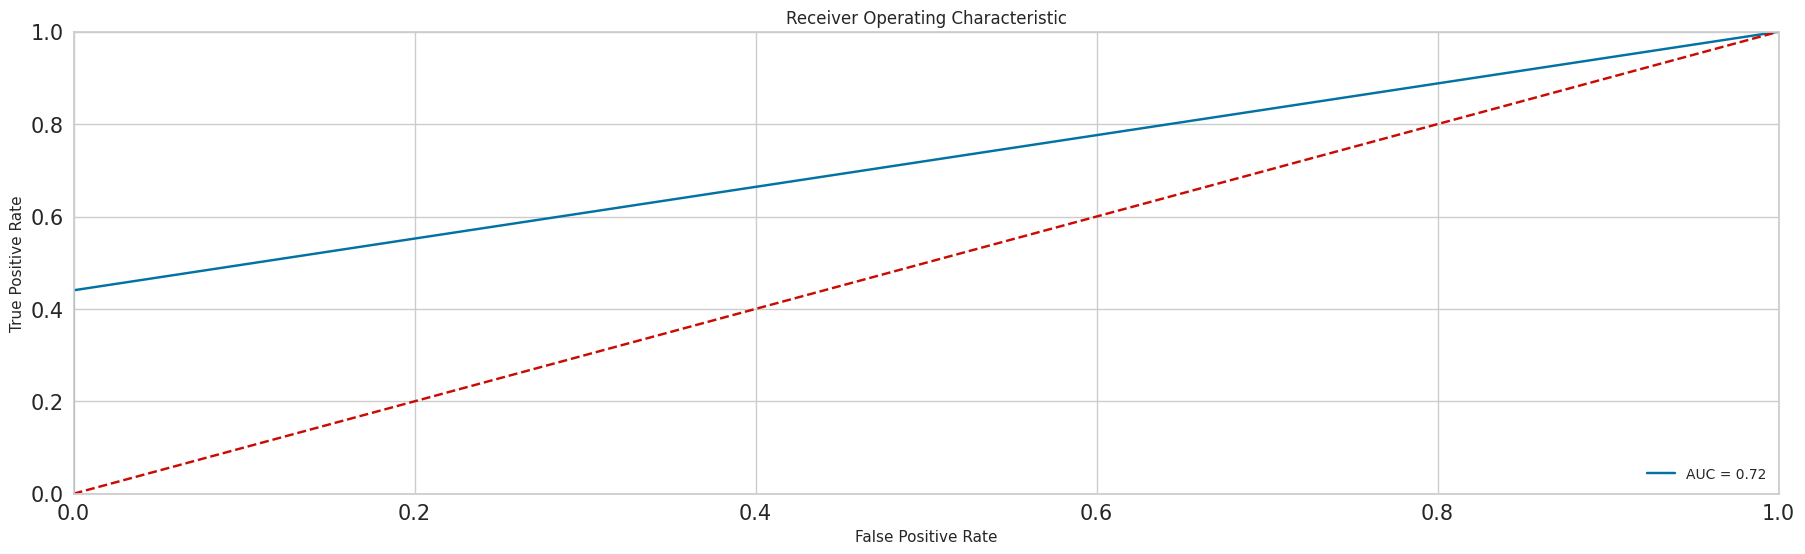

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    117030
           1       1.00      0.44      0.61      5478

    accuracy                           0.97    122508
   macro avg       0.99      0.72      0.80    122508
weighted avg       0.98      0.97      0.97    122508

Confusion Matrix: 
 [[117030      0]
 [  3066   2412]]

End of validation Result

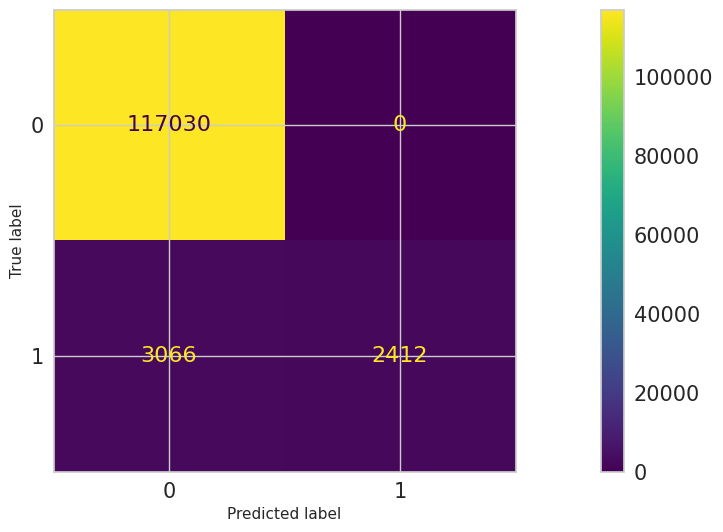

In [50]:
clf_score(cls_cat_boost, X_train_sm, y_train_sm, X_val, y_val, train=False)

## Multi-Layer Perceptron

A simple ANN architecture with Keras

In [52]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 51.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 130.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 38.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 110.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2024-09-15 01:10:56.486871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-15 01:10:56.569233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 01:10:56.601219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 01:10:56.610623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 01:10:56.668644: I tensorflow/core/platform/cpu_feature_guar

In [54]:
mlp = Sequential()
mlp.add(Dense(12, activation="relu", input_shape=(113,)))
mlp.add(Dense(8, activation="relu"))
mlp.add(Dense(1, activation="sigmoid"))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
mlp.output_shape
mlp.summary()
mlp.get_config()
mlp.get_weights()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │         1,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,481 (5.79 KB)

 Trainable params: 1,481 (5.79 KB)

 Non-trainable params: 0 (0.00 B)


[
    array([[-0.10793118, -0.20688188,  0.01941258, ..., -0.17718273,
         0.16061367,  0.20356397],
       [-0.10951401, -0.16280518, -0.05144045, ...,  0.14870657,
        -0.07730927, -0.2112672 ],
       [ 0.14238332,  0.15382864,  0.07539432, ..., -0.00151408,
         0.03513156, -0.05981804],
       ...,
       [ 0.20732097, -0.04932395, -0.13113272, ..., -0.06447425,
        -0.11072172,  0.21185975],
       [ 0.2112238 , -0.12175875, -0.12388278, ...,  0.11422376,
        -0.01317051,  0.14626996],
       [-0.03659472, -0.00491311,  0.01283714, ..., -0.0572474 ,
        -0.05192524, -0.21459405]], dtype=float32),
    array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
    array([[-0.01456755, -0.12517715, -0.34754813, -0.02224475,  0.13851076,
        -0.32678413, -0.5194887 ,  0.5032412 ],
       [-0.3164215 , -0.17754418, -0.32987082, -0.29500362, -0.38393745,
        -0.45448864, -0.45384172,  0.44138712],
       [-0.1930475 ,  0.40866637,  0.21443

In [56]:
mlp.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

train_y = np.asarray(y_train_sm)
mlp.fit(X_train_sm, train_y, epochs=3, batch_size=1, verbose=1)

Epoch 1/3


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 mlp.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])              │
│   2                                                                                              │
│   3 train_y = np.asarray(y_train_sm)                                                             │
│ ❱ 4 mlp.fit(X_train_sm, train_y, epochs=3, batch_size=1, verbose=1)                              │
│   5                                                                                              │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/utils/traceback_uti │
│ ls.py:122 in error_handler                                                                       │
│                                                                                                  │
│   119 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│   120 │   │   │   # To get the full stack trace, call:                                           │
│   121 │   │   │   # `keras.config.disable_traceback_filtering()`                                 │
│ ❱ 122 │   │   │   raise e.with_traceback(filtered_tb) from None                                  │
│   123 │   │   finally:                                                                           │
│   124 │   │   │   del filtered_tb                                                                │
│   125                                                                                            │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/input_spec.p │
│ y:227 in assert_input_compatibility                                                              │
│                                                                                                  │
│   224 │   │   │   │   │   value,                                                                 │
│   225 │   │   │   │   │   None,                                                                  │
│   226 │   │   │   │   }:                                                                         │
│ ❱ 227 │   │   │   │   │   raise ValueError(                                                      │
│   228 │   │   │   │   │   │   f'Input {input_index} of layer "{layer_name}" is '                 │
│   229 │   │   │   │   │   │   f"incompatible with the layer: expected axis {axis} "              │
│   230 │   │   │   │   │   │   f"of input shape to have value {value}, "                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 113, but
received input with shape (1, 103)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 103), dtype=float32)
  • training=True
  • mask=None

In [ ]:
y_pred = mlp.predict_classes(X_val)

In [ ]:
val_y = np.asarray(y_val)
score = mlp.evaluate(X_val, val_y, verbose=1)
print(score)

In [ ]:
evaluation_metrics(y_val, y_pred)

## AdaNet

In [58]:
!pip install adanet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 95.0 MB/s eta 0:00:00
  Created wheel for coverage: filename=coverage-4.5.4-cp310-cp310-linux_x86_64.whl size=180445 sha256=d83b2146c8dc0521b112e2aca24be023d84cbb537188311a9c7dbe7cd5ddd540
  Stored in directory: /home/zeus/.cache/pip/wheels/24/3b/59/8b5b481efbac60694af4d7d281e8b27461384fcbd51ae53c8e
  Created wheel for rednose: filename=rednose-1.3.0-py3-none-any.whl size=12133 sha256=5c70881b30f0ac78012ce549ccdd37ff74278d70f592cbf7a6f2b6a6cc2227a4
  Stored in directory: /home/zeus/.cache/pip/wheels/c6/53/c2/77c709addec36a143404f55bb2a9d9b849a974603c21cf4586
  Created wheel for termstyle: filename=termstyle-0.1.11-py3-none-any.whl size=4761 sha256=9de8f5275201366f82af1d9edadc77a3b6dc219a9c5c6d2e1011fedd494c4b74
  Stored in directory: /home/zeus/.cache/pip/wheels/f0/fd/d9/30607665fa0795f753ab5ade8c08924eb5047862

In [ ]:
import adanet
import tensorflow as tf

# Define the model head for computing loss and evaluation metrics.
head = MultiClassHead(n_classes=10)

# Feature columns define how to process examples.
feature_columns = ...

# Learn to ensemble linear and neural network models.
estimator = adanet.AutoEnsembleEstimator(
    head=head,
    candidate_pool=lambda config: {
        "linear": tf.estimator.LinearEstimator(
            head=head, feature_columns=feature_columns, config=config, optimizer="adam"
        ),
        "dnn": tf.estimator.DNNEstimator(
            head=head,
            feature_columns=feature_columns,
            config=config,
            optimizer="adam",
            hidden_units=[1000, 500, 100],
        ),
    },
    max_iteration_steps=50,
)

estimator.train(input_fn=train_input_fn, steps=100)
metrics = estimator.evaluate(input_fn=eval_input_fn)
predictions = estimator.predict(input_fn=predict_input_fn)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 import adanet                                                                               │
│    2 import tensorflow as tf                                                                     │
│    3                                                                                             │
│    4 # Define the model head for computing loss and evaluation metrics.                          │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/adanet/__init__.py:21 in      │
│ <module>                                                                                         │
│                                                                                                  │
│   18 from __future__ import division                                                             │
│   19 from __future__ import print_function                                                       │
│   20                                                                                             │
│ ❱ 21 from adanet import distributed                                                              │
│   22 from adanet import ensemble                                                                 │
│   23 from adanet import replay                                                                   │
│   24 from adanet import subnetwork                                                               │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/adanet/distributed/__init__.p │
│ y:26 in <module>                                                                                 │
│                                                                                                  │
│   23 from __future__ import division                                                             │
│   24 from __future__ import print_function                                                       │
│   25                                                                                             │
│ ❱ 26 from adanet.distributed.placement import PlacementStrategy                                  │
│   27 from adanet.distributed.placement import ReplicationStrategy                                │
│   28 from adanet.distributed.placement import RoundRobinStrategy                                 │
│   29                                                                                             │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/adanet/distributed/placement. │
│ py:24 in <module>                                                                                │
│                                                                                                  │
│    21 import contextlib                                                                          │
│    22                                                                                            │
│    23 from absl import logging                                                                   │
│ ❱  24 from adanet import tf_compat                                                               │
│    25 from adanet.distributed.devices import _OpNameHashStrategy                                 │
│    26 import numpy as np                                                                         │
│    27 import six                                           

## TPOT

In [60]:
! pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 256.5 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=7e750d2fce24356d48db3617250cea225e47215115e560e441ba9056281cde7d
  Stored in directory: /home/zeus/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [61]:
from tpot import TPOTClassifier

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/stopit/__init__.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pkg_resources/__init__.py:3144: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


In [63]:
# https://epistasislab.github.io/tpot/using/#built-in-tpot-configurations
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, 
                      random_state=42, config_dict='TPOT light')
tpot.fit(X_train_sm, y_train_sm)
print(tpot.score(X_val, y_val))
tpot.export('tpot_exported_pipeline.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -inf


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tpot/base.py:1164: DeprecationWarning: invalid escape sequence '\w'
  (m.start(), m.end()) for m in re.finditer(", [\w]+__", dirty_string)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tpot/base.py:817 in fit       │
│                                                                                                  │
│    814 │   │   │   with warnings.catch_warnings():                                               │
│    815 │   │   │   │   self._setup_memory()                                                      │
│    816 │   │   │   │   warnings.simplefilter("ignore")                                           │
│ ❱  817 │   │   │   │   self._pop, _ = eaMuPlusLambda(                                            │
│    818 │   │   │   │   │   population=self._pop,                                                 │
│    819 │   │   │   │   │   toolbox=self._toolbox,                                                │
│    820 │   │   │   │   │   mu=self.population_size,                                              │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tpot/gp_deap.py:285 in        │
│ eaMuPlusLambda                                                                                   │
│                                                                                                  │
│   282 │   │                                                                                      │
│   283 │   │   # after each population save a periodic pipeline                                   │
│   284 │   │   if per_generation_function is not None:                                            │
│ ❱ 285 │   │   │   per_generation_function(gen)                                                   │
│   286 │   │                                                                                      │
│   287 │   │   # Update the statistics with the new population                                    │
│   288 │   │   record = stats.compile(population) if stats is not None else {}                    │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tpot/base.py:1184 in          │
│ _check_periodic_pipeline                                                                         │
│                                                                                                  │
│   1181 │   │   -------                                                                           │
│   1182 │   │   None                                                                              │
│   1183 │   │   """                                                                               │
│ ❱ 1184 │   │   self._update_top_pipeline()                                                       │
│   1185 │   │   if self.periodic_checkpoint_folder is not None:                                   │
│   1186 │   │   │   total_since_last_pipeline_save = (                                            │
│   1187 │   │   │   │   datetime.now() - self._last_pipeline_write                                │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tpot/base.py:935 in           │
│ _update_top_pipeline                                                                             │
│                                                                                                  │
│    932 │   │   │   │   │   │   │   error_score="raise",                                          │
│    933 │   │   │   │   │   │   )                                                                 │
│    934 │   │   │   │   │   │   break                                                             │
│ ❱  935 │   │   │   │   raise RuntimeError(                 

## AutoKeras

In [ ]:
! pip install autokeras==1.0.0b0

In [ ]:
import autokeras as ak

In [ ]:
# It tries 10 different models.
clf_auto_keras = ak.StructuredDataClassifier(max_trials=10)
# Feed the structured data classifier with training data.
clf_auto_keras.fit(X_train_small, y_train_small)
# Predict with the best model.
predicted_y = clf_auto_keras.predict(X_val)
# Evaluate the best model with testing data.
print(clf_auto_keras.evaluate(X_val, y_val))

## Try different classifiers

In [ ]:
# free up some memory
gc.collect()

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
for model in [
    DecisionTreeClassifier,
    GaussianNB,
    SVC,
    KNeighborsClassifier,
]:
    clf = model()
    clf.fit(X_train_small, y_train_small)
    print(f"{model.__name__:22}")
    clf_score(clf, X_train_sm, y_train_sm, X_val, y_val, train=False)

In [ ]:
for model in [
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
]:
    cls = model()
    kfold = model_selection.KFold(
        n_splits=10, random_state=42
    )
    s = model_selection.cross_val_score(
        cls, X_train_sm, y_train_sm, scoring="roc_auc", cv=kfold
    )
    print(
        f"{model.__name__:22}  AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}"
    )

In [ ]:
for model in [
        DummyClassifier,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
        xgboost.XGBClassifier,
]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    s = model_selection.cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)
    print(f"{model.__name__:22}  AUC: " f"{s.mean():.3f} STD: {s.std():.2f}")

## Stacked Ensemble

In [ ]:
from mlxtend.classifier import (
    StackingClassifier,
)

clfs = [
    x() for x in [
        DecisionTreeClassifier,
        LogisticRegression,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
    ]
]
stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(n_splits=10, random_state=42)
s = model_selection.cross_val_score(stack, X, y, scoring="roc_auc", cv=kfold)
print(f"{stack.__class__.__name__}  "
      f"AUC: {s.mean():.3f}  STD: {s.std():.2f}")

## Pickle the model

In [ ]:
import pickle

pic = pickle.dumps(clf_rf_best)
clf_rf_pickled = pickle.loads(pic)
y_pred = clf_rf_pickled.predict(X_test)
roc_auc_score(y_test, y_pred)